<a href="https://colab.research.google.com/github/J0hnArren/Time-Series-Forecasting/blob/main/time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
wget https://studre.ru/assets/uploads/files/_данные_20210506164553.zip
unzip *.zip
rm -r *.zip
rm -r /content/__MACOSX

Archive:  _данные_20210506164553.zip
   creating: Вспомогательные данные/
  inflating: __MACOSX/._Вспомогательные данные  
  inflating: Вспомогательные данные/.DS_Store  
  inflating: __MACOSX/Вспомогательные данные/._.DS_Store  
  inflating: Вспомогательные данные/Рисунок 1.png  
  inflating: __MACOSX/Вспомогательные данные/._Рисунок 1.png  
  inflating: Вспомогательные данные/data.csv  
  inflating: __MACOSX/Вспомогательные данные/._data.csv  


--2022-08-20 19:36:58--  https://studre.ru/assets/uploads/files/_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5_20210506164553.zip
Resolving studre.ru (studre.ru)... 92.53.96.249, 2a03:6f00:1::5c35:60f9
Connecting to studre.ru (studre.ru)|92.53.96.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350838 (343K) [application/zip]
Saving to: ‘_данные_20210506164553.zip’

     0K .......... .......... .......... .......... .......... 14%  288K 1s
    50K .......... .......... .......... .......... .......... 29%  288K 1s
   100K .......... .......... .......... .......... .......... 43% 38.2M 0s
   150K .......... .......... .......... .......... .......... 58%  291K 0s
   200K .......... .......... .......... .......... .......... 72% 47.0M 0s
   250K .......... .......... .......... .......... .......... 87% 28.1M 0s
   300K .......... .......... .......... .......... ..        100% 35.2M=0.5s

2022-08-20 19:37:00 (654 KB/s) - ‘_данные_20210506164553.zip’ saved [350838/

## Вводные данные задачи

В файле data.csv (находится в архиве "Вспомогательный данные") представлены подневные данные объема расчетных счетов физических лиц. В отличие от депозита, клиент может снять всю сумму с расчетного счета в любой момент времени без каких-либо «штрафов». Такой продукт называют Undefined Maturity Product – UMP). Однако маловероятно, что все клиенты разом закроют свои счета в Банке. Всегда кто-то снимает деньги, а кто-то пополняет счет – есть некоторый стабильный уровень, ниже которого не опустится суммарный обьем расчетных счетов.

Например, если бы мы знали будущее объема расчетных счетов, как на рисунке 1 (находится в архиве "Вспомогательный данные"), то стабильная часть на 1 месяц (1м) была бы на уровне, обозначенным красным цветом. Это тот уровень, который не пробивается на протяжении 1 месяца. Аналогично 2м – зеленый, 3м – синий, 4м – розовый.



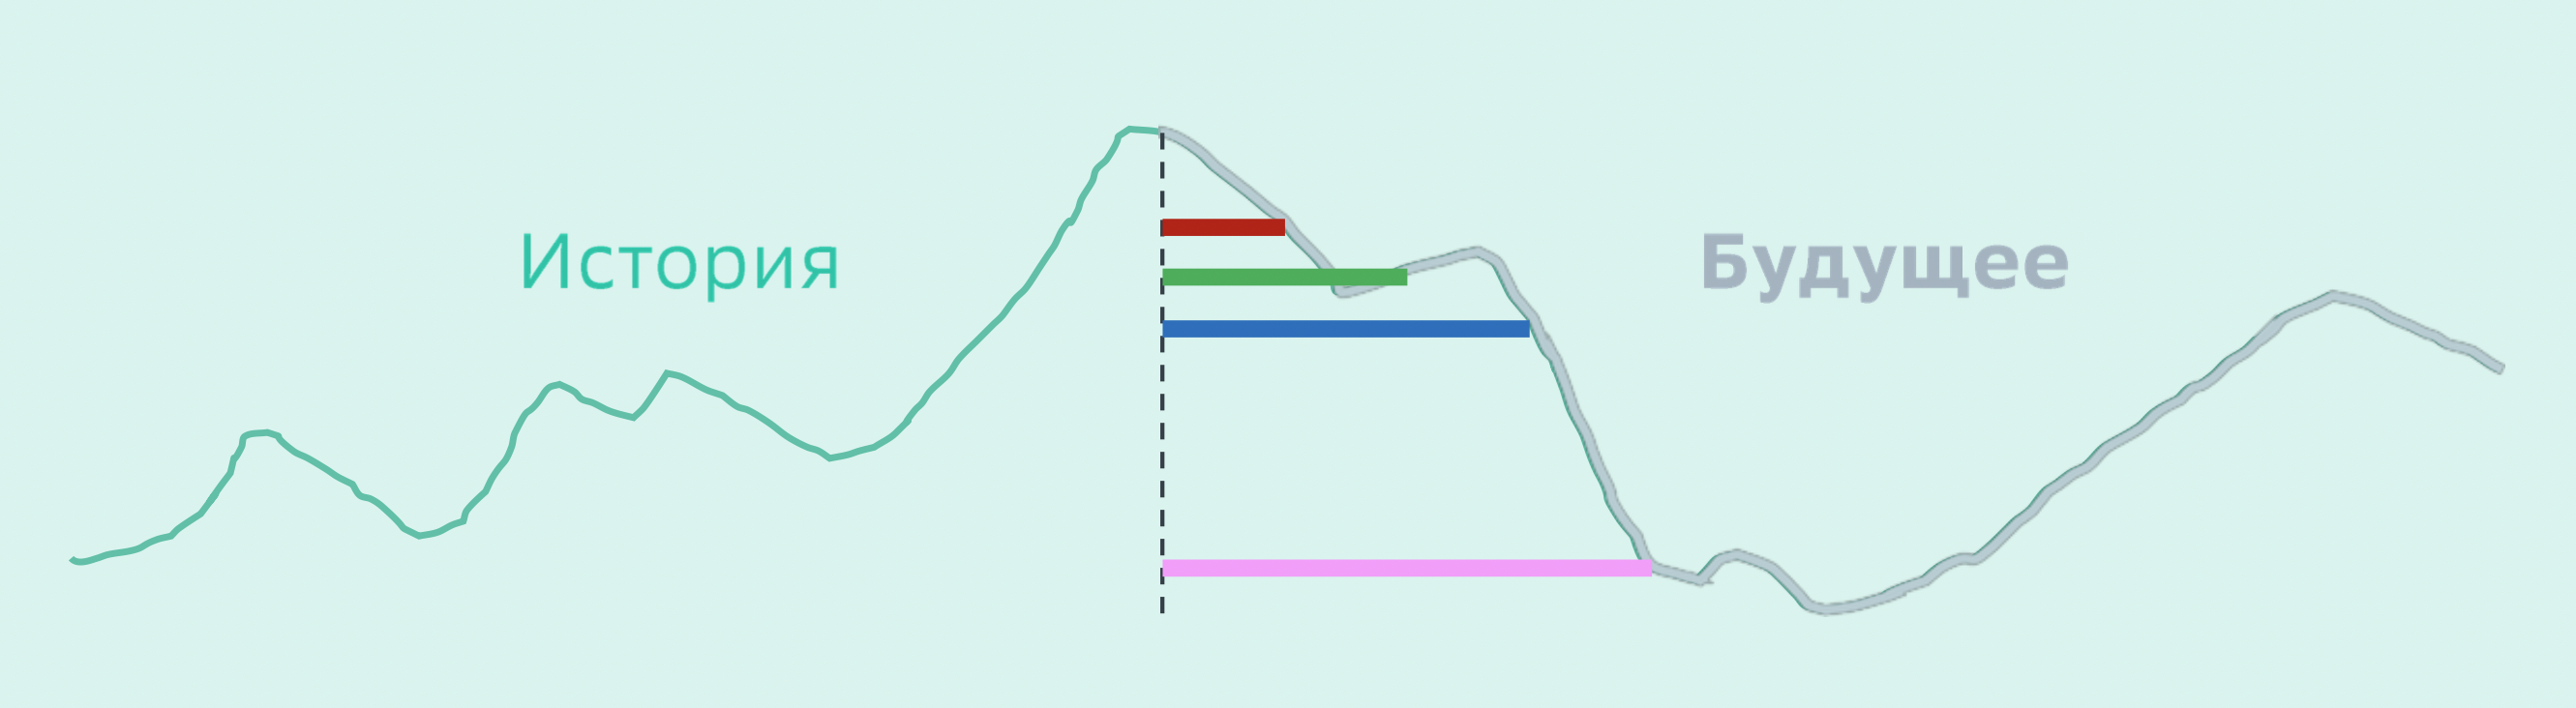

In [ ]:
from IPython.display import Image
Image('/content/Вспомогательные данные/Рисунок 1.png')

## Описание задачи

Для временного ряда в файле data.csv необходимо построить модель, которая оценивает обьем стабильной части средств на дату. 

Например:

model_forecast

(2019-02-01, ‘1М’, История_до_2019-02-01) = стабильная часть на 1М

Возможные горизонты: 1М, 2М, 3М, 4М, 5М, 6М, 7М, 8М, 9М, 10М, 11М, 12М

Критерии качества модели:

Нужно одновременно минимизировать величины:

* максимальный объем пробития стабильный части на валидационной выборке 
* фактическая стабильная часть – модельная стабильная часть 

Можно применять любые подходы. Как вариант: построить квантильную регрессию для прогнозирования ряда.

## Реализация

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

### Датасет


In [ ]:
data = pd.read_csv('/content/Вспомогательные данные/data.csv', sep=';', parse_dates=[0])
data = data.rename(columns={'REPORTDATE': 'ds', 'VALUE': 'val'})
data = data.set_index('ds')
#data['val'] = data.val.apply(np.log)
data.head()

,val
ds,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-02-01,3417092149
2014-03-01,3417092149


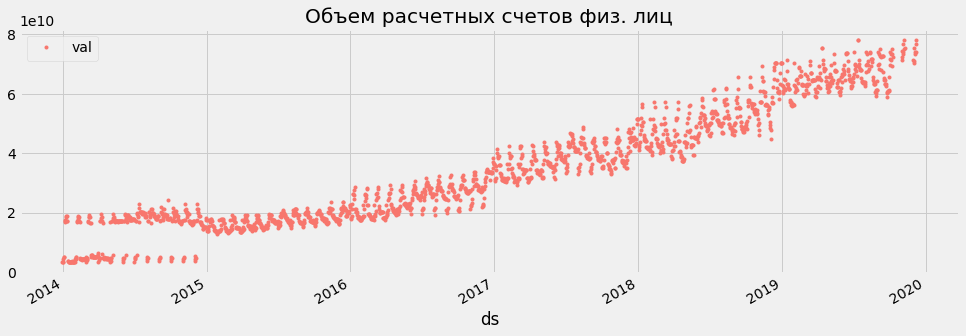

In [ ]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
data.plot(style='.', figsize=(15,5), color=color_pal[0], title='Объем расчетных счетов физ. лиц')
plt.show()

### Разведочный анализ данных

Cоздадим некоторые функции для временных рядов, чтобы увидеть, как на тенденции влияют день недели, время года и т.д.

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(data, label='val')

features_and_target = pd.concat([X, y], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [ ]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,val
ds,,,,,,,,,
2013-12-30,0,0,4,12,2013,364,30,1,3457625638
2013-12-31,0,1,4,12,2013,365,31,1,3417092149
2014-01-01,0,2,1,1,2014,1,1,1,3417092149
2014-02-01,0,5,1,2,2014,32,1,5,3417092149
2014-03-01,0,5,1,3,2014,60,1,9,3417092149


### Разделение Train/Test 
Отрежем данные после 14.08.2018 на валидационную часть, период 1 год 1 месяц и 26 дней. Данные ранее этой даты пойдут на обучение (разделение 20% и 80%). 

In [ ]:
split_date = '2018-08-14'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

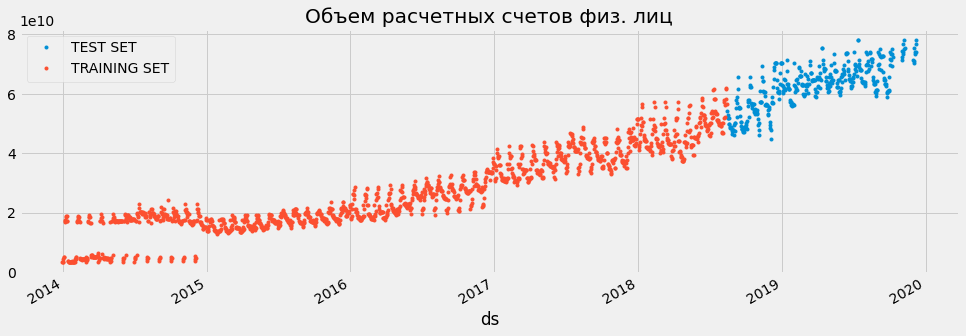

In [ ]:
# Plot train and test so you can see where we have split
data_test \
    .rename(columns={'val': 'TEST SET'}) \
    .join(data_train.rename(columns={'val': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Объем расчетных счетов физ. лиц', style='.')
plt.show()

### Простая модель Prophet
Модель Prophet ожидает, что набор данных будет назван определенным образом. Переименуем столбцы фрейма данных, прежде чем вводить их в модель.

In [ ]:
# Format data for prophet model using ds and y
data_train.reset_index() \
    .rename(columns={'ds':'ds', 'val':'y'}).head()

,ds,y
0,2013-12-30,3457625638
1,2013-12-31,3417092149
2,2014-01-01,3417092149
3,2014-02-01,3417092149
4,2014-03-01,3417092149


In [ ]:
# Setup and train model and fit
model = Prophet()
model.fit(data_train.reset_index().rename(columns={'ds':'ds', 'val':'y'}))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpssysj3xl/6t6qjubz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpssysj3xl/pg0xyhru.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10041', 'data', 'file=/tmp/tmpssysj3xl/6t6qjubz.json', 'init=/tmp/tmpssysj3xl/pg0xyhru.json', 'output', 'file=/tmp/tmplkm_r35j/prophet_model-20220820193704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:37:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:37:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Predict on training set with model
data_test_fcst = model.predict(df=data_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [ ]:
data_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-08-15,5.059437e+10,4.684291e+10,5.643669e+10,5.059437e+10,5.059437e+10,1.086055e+09,1.086055e+09,1.086055e+09,-6.430567e+07,-6.430567e+07,-6.430567e+07,1.150360e+09,1.150360e+09,1.150360e+09,0.0,0.0,0.0,5.168042e+10
1,2018-08-16,5.062512e+10,4.687191e+10,5.677088e+10,5.062512e+10,5.062512e+10,1.188247e+09,1.188247e+09,1.188247e+09,4.641484e+07,4.641484e+07,4.641484e+07,1.141832e+09,1.141832e+09,1.141832e+09,0.0,0.0,0.0,5.181336e+10
2,2018-08-17,5.065586e+10,4.640349e+10,5.610434e+10,5.065586e+10,5.065586e+10,1.125744e+09,1.125744e+09,1.125744e+09,-1.184411e+07,-1.184411e+07,-1.184411e+07,1.137588e+09,1.137588e+09,1.137588e+09,0.0,0.0,0.0,5.178161e+10
3,2018-08-18,5.068661e+10,4.707648e+10,5.650933e+10,5.068661e+10,5.068661e+10,1.255502e+09,1.255502e+09,1.255502e+09,1.192167e+08,1.192167e+08,1.192167e+08,1.136286e+09,1.136286e+09,1.136286e+09,0.0,0.0,0.0,5.194211e+10
4,2018-08-19,5.071736e+10,4.716629e+10,5.733287e+10,5.071736e+10,5.071736e+10,1.541448e+09,1.541448e+09,1.541448e+09,4.049940e+08,4.049940e+08,4.049940e+08,1.136454e+09,1.136454e+09,1.136454e+09,0.0,0.0,0.0,5.225881e+10


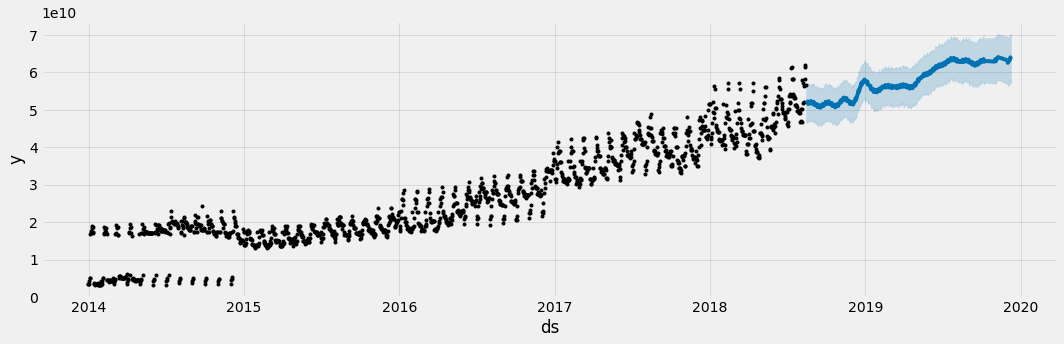

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(data_test_fcst, ax=ax)
plt.show()

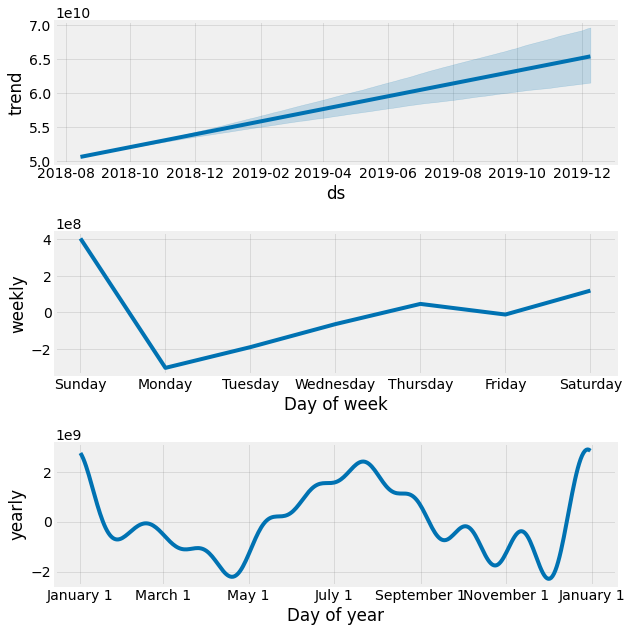

In [ ]:
# Plot the components of the model
fig = model.plot_components(data_test_fcst)

### Сравние прогноза с реальными данными

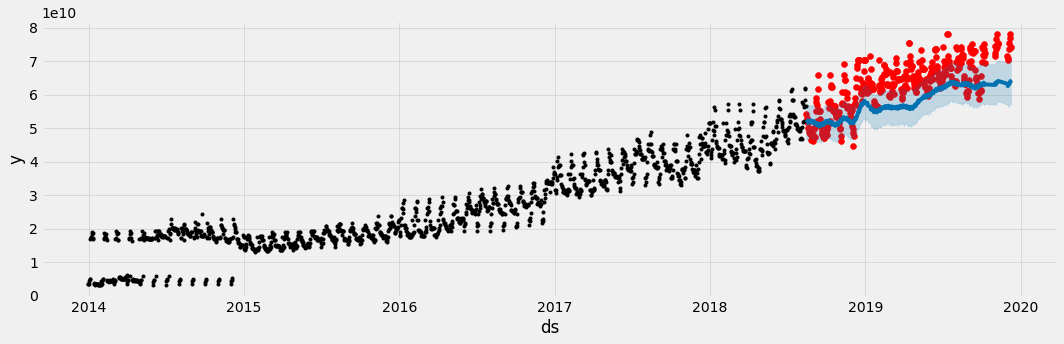

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test.index, data_test['val'], color='r')
fig = model.plot(data_test_fcst, ax=ax)

### Визуализация предсказания на годовом периоде тестовой выборки

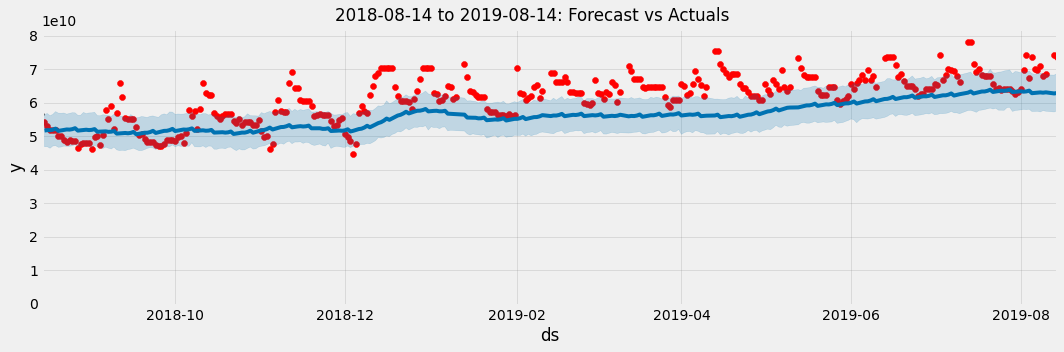

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test.index, data_test['val'], color='r')
fig = model.plot(data_test_fcst, ax=ax)
ax.set_xbound(lower='2018-08-14', upper='2019-08-14')
#ax.set_ylim(0, 60000)
plot = plt.suptitle('2018-08-14 to 2019-08-14: Forecast vs Actuals')

### Показатели ошибок
    Ошибка RMSE равна 6.07
    Ошибка MAE составляет 6238391302.56
    Ошибка MAPE составляет 9.5%

In [ ]:
mean_squared_error(y_true=data_test['val'],
                   y_pred=data_test_fcst['yhat'])

6.072330761676373e+19

In [ ]:
mean_absolute_error(y_true=data_test['val'],
                   y_pred=data_test_fcst['yhat'])

6238391302.560711

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=data_test['val'],
                   y_pred=data_test_fcst['yhat'])

9.502178440211846

### Добавление праздников
Далее посмотрим, поможет ли добавление индикаторов праздничных дней точности модели. Prophet поставляется с параметром праздничных эффектов, который может быть предоставлен модели перед обучением.


In [ ]:
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar
from datetime import datetime

class RussianHolidays(AbstractHolidayCalendar):
    rules = [Holiday('New Years Day', month=1, day=1),
             Holiday('New Years Day', month=1, day=2),
             Holiday('New Years Day', month=1, day=3),
             Holiday('New Years Day', month=1, day=4),
             Holiday('New Years Day', month=1, day=5),
             Holiday('New Years Day', month=1, day=6),
             Holiday('New Years Day', month=1, day=7),
             Holiday('New Years Day', month=1, day=8),
             Holiday('Defense of the Fatherland Day', month=2, day=23),
             Holiday('International Womens Day', month=3, day=8),
             Holiday('Spring and Labour day', month=5, day=1),
             Holiday('Victory Day', month=5, day=9),
             Holiday('Russia Day', month=6, day=12),
             Holiday('Unity Day', month=11, day=4),
            ]

cal = RussianHolidays()

In [ ]:
train_holidays = cal.holidays(start=data_train.index.min(),
                              end=data_train.index.max())
test_holidays = cal.holidays(start=data_test.index.min(),
                             end=data_test.index.max())

In [ ]:
# Create a dataframe with holiday, ds columns
data['date'] = data.index.date
data['is_holiday'] = data.date.isin([d.date() for d in cal.holidays()])
holiday_df = data.loc[data['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'RussianFederalHoliday'
holiday_df = holiday_df.drop(['val','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2014-01-01,RussianFederalHoliday
1,2014-05-01,RussianFederalHoliday
2,2014-01-02,RussianFederalHoliday
3,2014-02-23,RussianFederalHoliday
4,2014-01-03,RussianFederalHoliday


In [ ]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [ ]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(data_train.reset_index() \
                            .rename(columns={'Datetime':'ds',
                                             'val':'y'}))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpssysj3xl/wt7mvcfa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpssysj3xl/foo7t62b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46457', 'data', 'file=/tmp/tmpssysj3xl/wt7mvcfa.json', 'init=/tmp/tmpssysj3xl/foo7t62b.json', 'output', 'file=/tmp/tmpd8dfewbj/prophet_model-20220820194219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:42:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:42:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#### Прогнозируй С Праздниками

In [ ]:
# Predict on training set with model
data_test_fcst_with_hols = \
    model_with_holidays.predict(df=data_test.reset_index() \
                                    .rename(columns={'Datetime':'ds'}))

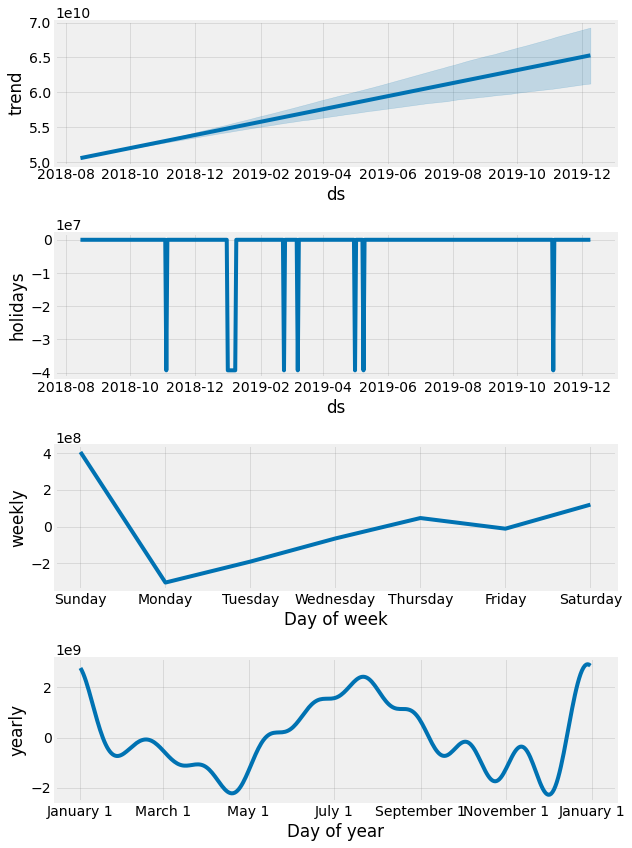

In [ ]:
fig2 = model_with_holidays.plot_components(data_test_fcst_with_hols)

#### Показатели ошибок с добавлением праздников
Удивительно, но точность ухудшилась после добавления праздников.

In [ ]:
mean_squared_error(y_true=data_test['val'],
                   y_pred=data_test_fcst_with_hols['yhat'])

6.135926563239552e+19

In [ ]:
mean_absolute_error(y_true=data_test['val'],
                   y_pred=data_test_fcst_with_hols['yhat'])

6279189390.100579

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=data_test['val'],
                   y_pred=data_test_fcst_with_hols['yhat'])

9.562969303359502

#### Сравнение моделей
Давайте построим прогнозную модель с праздничными днями и без них на новогодние выходные. Похоже, что каких то заметных значений точности обнаружить не удалось.

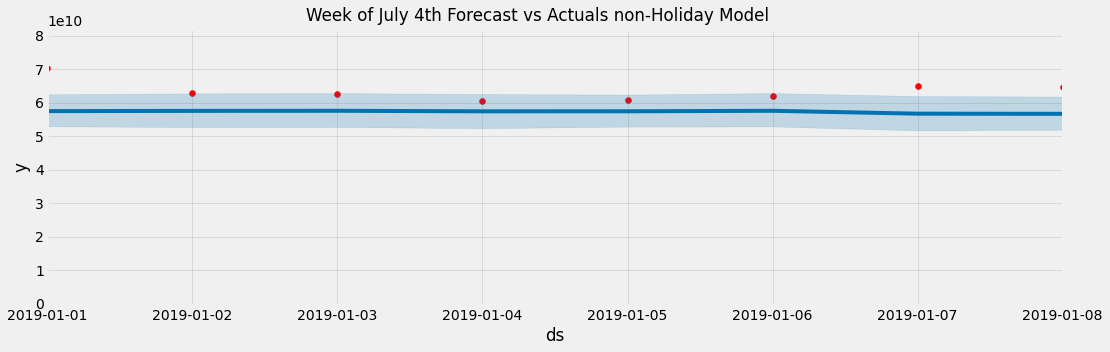

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test.index, data_test['val'], color='r')
fig = model.plot(data_test_fcst, ax=ax)
ax.set_xbound(lower='2019-01-01', upper='2019-01-08')
#ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals non-Holiday Model')

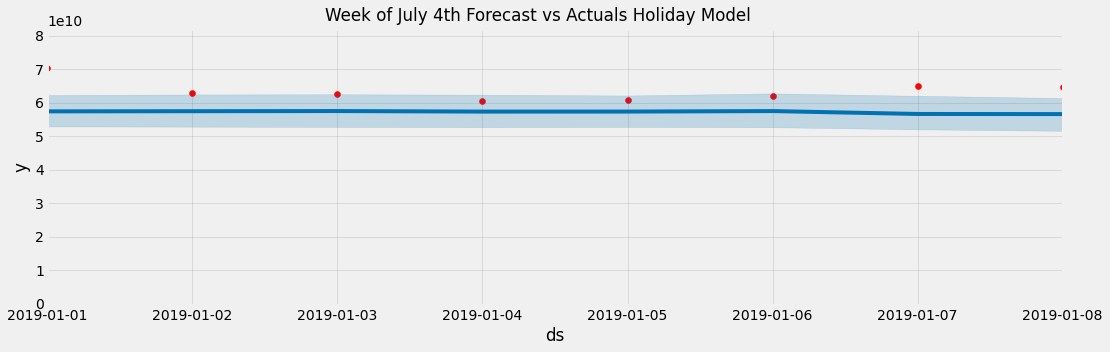

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test.index, data_test['val'], color='r')
fig = model.plot(data_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower='2019-01-01', upper='2019-01-08')
# ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals Holiday Model')

#### Сравнение ошибок на новогодние праздники

Очень незначительно точность выросла на эти дни

In [ ]:
ny_test = data_test.query('ds >= 20190101 and ds < 20190108')
ny_pred = data_test_fcst.query('ds >= 20190101 and ds < 20190108')
ny_pred_holiday_model = data_test_fcst_with_hols.query('ds >= 20190101 and ds < 20190108')

In [ ]:
mean_absolute_error(y_true=ny_test['val'],
                   y_pred=ny_pred['yhat'])

6017555475.384361

In [ ]:
mean_absolute_error(y_true=ny_test['val'],
                   y_pred=ny_pred_holiday_model['yhat'])

6099709450.1297455

#### Ошибка на все выходные

Праздничная ошибка повысилась! Это неожиданно.

In [ ]:
holiday_list = holiday_df['ds'].tolist()

In [ ]:
hols_test = data_test.query('ds in @holiday_list')
hols_pred = data_test_fcst.query('ds in @holiday_list')
hols_pred_holiday_model = data_test_fcst_with_hols.query('ds in @holiday_list')

In [ ]:
mean_absolute_error(y_true=hols_test['val'],
                   y_pred=hols_pred['yhat'])

7101061850.615411

In [ ]:
mean_absolute_error(y_true=hols_test['val'],
                   y_pred=hols_pred_holiday_model['yhat'])

7181223119.961931

#### Определить ошибку по праздникам
Мы можем видеть, что разные праздники реагируют по-разному в этой модели. Модель работала бы лучше, если бы пракздники определялись конкретнее, а не были объединены все вместе как "федеральные праздники"

In [ ]:
holiday_df['date'] = holiday_df['ds'].dt.date

for hol, d in holiday_df.groupby('date'):
    holiday_list = d['ds'].tolist()
    hols_test = data_test.query('ds in @holiday_list')
    if len(hols_test) == 0:
        continue
    hols_pred = data_test_fcst.query('ds in @holiday_list')
    hols_pred_holiday_model = data_test_fcst_with_hols.query('ds in @holiday_list')
    non_hol_error = mean_absolute_error(y_true=hols_test['val'],
                   y_pred=hols_pred['yhat'])
    hol_model_error = mean_absolute_error(y_true=hols_test['val'],
                       y_pred=hols_pred_holiday_model['yhat'])
    diff = non_hol_error - hol_model_error
    print(f'Holiday: {hol:%B %d, %Y}:    \n MAE (non-holiday model): {non_hol_error:0.4f} \n MAE (Holiday Model): {hol_model_error:0.4f} \n Diff {diff:0.4f}')

Holiday: November 04, 2018:    
 MAE (non-holiday model): 6374249271.0750 
 MAE (Holiday Model): 6318428497.2930 
 Diff 55820773.7820
Holiday: January 01, 2019:    
 MAE (non-holiday model): 12804027287.5519 
 MAE (Holiday Model): 12880160772.9357 
 Diff -76133485.3838
Holiday: January 02, 2019:    
 MAE (non-holiday model): 5270880034.3052 
 MAE (Holiday Model): 5349262500.4293 
 Diff -78382466.1240
Holiday: January 03, 2019:    
 MAE (non-holiday model): 5067704639.4591 
 MAE (Holiday Model): 5147769086.2381 
 Diff -80064446.7790
Holiday: January 04, 2019:    
 MAE (non-holiday model): 3019739579.1743 
 MAE (Holiday Model): 3101547595.8089 
 Diff -81808016.6346
Holiday: January 05, 2019:    
 MAE (non-holiday model): 3477498577.5943 
 MAE (Holiday Model): 3561697313.8979 
 Diff -84198736.3036
Holiday: January 06, 2019:    
 MAE (non-holiday model): 4334458133.5933 
 MAE (Holiday Model): 4420227872.7131 
 Diff -85769739.1198
Holiday: January 07, 2019:    
 MAE (non-holiday model): 814

#### Ошибка построения графика каждого прогноза
Мы видим, что обе наши модели хорошо обобщают, но испытывают трудности в дни пикового спроса.
Похоже, прогнозируется много дней.

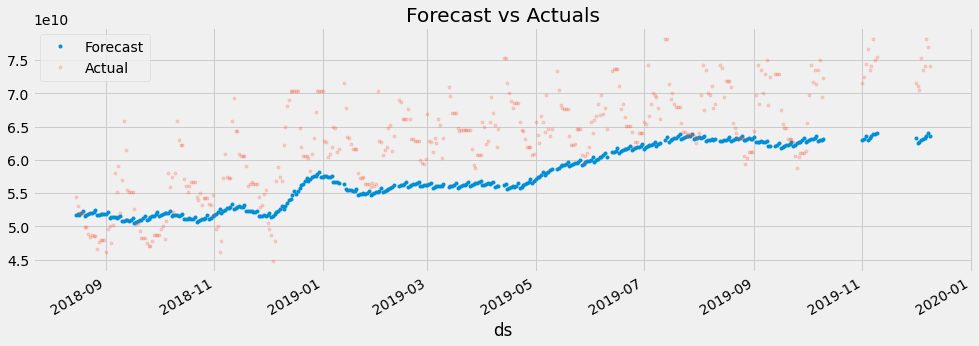

In [ ]:
ax = data_test_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=0,
                                                 style='.')
data_test['val'].plot(ax=ax,
                          style='.',
                          lw=0,
                          alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals')
plt.show()

### Очистка данных

Если входные данные содержат значения-выбросы, прогноз будет использовать их при составлении предсказаний и может вызвать серьезные неточности.
Заметим, что в обучающих данных, что у нас есть некоторые плохие измерения, где значения намного меньше. Может ли это быть причиной занижения прогноза? Давайте попробуем удалить эти выбросы.
На этом графике показаны значения выбросы, выделенные красным цветом.

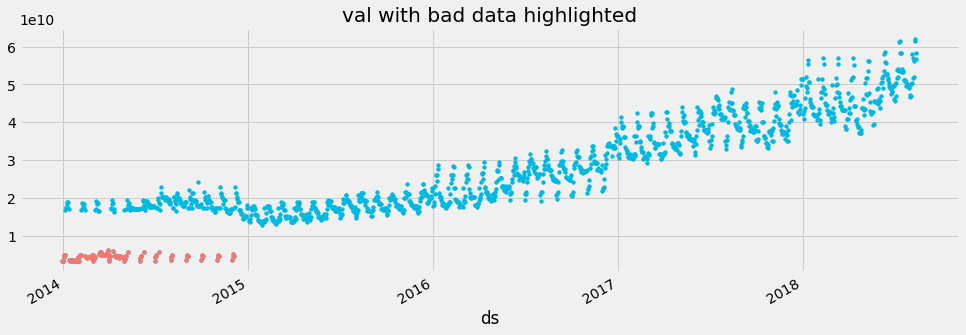

In [ ]:
ax = data_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='val with bad data highlighted',
                     #xlim=('2018-08-14', '2019-08-14')
                    )
data_train.query('val < 6500000000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

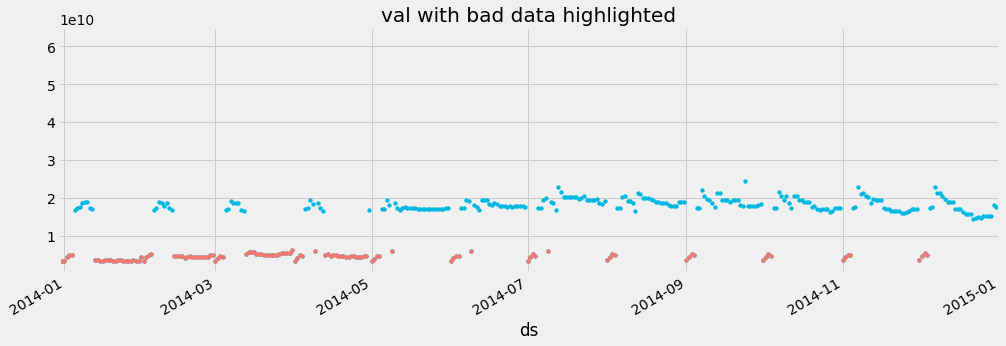

In [ ]:
ax = data_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='val with bad data highlighted',
                     xlim=('2013-12-30','2015-01-01')
                    )
data_train.query('val < 6500000000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

In [ ]:
# Clean Data
data_train['val_clean'] = data_train['val']
data_train.loc[data_train['val'] < 23, 'val_clean'] = np.nan

# Train model on clean data
model = Prophet()
model.fit(data_train.reset_index() \
              .rename(columns={'ds':'ds',
                               'val_clean':'y'})
         )

# Predict on training set with clean model
data_test_fcst_clean = model.predict(df=data_test.reset_index())

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpssysj3xl/hnvxcb_z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpssysj3xl/7iuyjxfo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4569', 'data', 'file=/tmp/tmpssysj3xl/hnvxcb_z.json', 'init=/tmp/tmpssysj3xl/7iuyjxfo.json', 'output', 'file=/tmp/tmpohbha9y7/prophet_model-20220820222002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:20:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:20:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
data_test_fcst_clean.sample(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
43,2018-09-27,5.191651e+10,4.692405e+10,5.628260e+10,5.184578e+10,5.198479e+10,-3.289534e+08,-3.289534e+08,-3.289534e+08,4.641484e+07,4.641484e+07,4.641484e+07,-3.753683e+08,-3.753683e+08,-3.753683e+08,0.0,0.0,0.0,5.158756e+10
11,2018-08-26,5.093259e+10,4.770834e+10,5.758385e+10,5.093259e+10,5.093259e+10,1.455071e+09,1.455071e+09,1.455071e+09,4.049940e+08,4.049940e+08,4.049940e+08,1.050077e+09,1.050077e+09,1.050077e+09,0.0,0.0,0.0,5.238766e+10
179,2019-02-14,5.622116e+10,5.112714e+10,6.114936e+10,5.534051e+10,5.719167e+10,-5.041004e+07,-5.041004e+07,-5.041004e+07,4.641484e+07,4.641484e+07,4.641484e+07,-9.682488e+07,-9.682488e+07,-9.682488e+07,0.0,0.0,0.0,5.617075e+10
40,2018-09-24,5.182427e+10,4.594265e+10,5.596130e+10,5.176521e+10,5.187855e+10,-8.510185e+08,-8.510185e+08,-8.510185e+08,-3.041024e+08,-3.041024e+08,-3.041024e+08,-5.469161e+08,-5.469161e+08,-5.469161e+08,0.0,0.0,0.0,5.097325e+10
154,2019-01-18,5.539097e+10,5.017029e+10,6.061846e+10,5.469023e+10,5.610682e+10,-6.979130e+07,-6.979130e+07,-6.979130e+07,-1.184411e+07,-1.184411e+07,-1.184411e+07,-5.794719e+07,-5.794719e+07,-5.794719e+07,0.0,0.0,0.0,5.532118e+10


После очистки заметно небольшое улучшение показателей по сравнению с первой моделью. Дополнительная очистка данных наряду с учетом праздничных дней может привести к еще лучшим результатам.

In [ ]:
mse_clean = mean_squared_error(y_true=data_test['val'],
                               y_pred=data_test_fcst_clean['yhat']
                              )
mae_clean = mean_absolute_error(y_true=data_test['val'],
                                y_pred=data_test_fcst_clean['yhat']
                               )
mape_clean = mean_absolute_percentage_error(y_true=data_test['val'],
                                            y_pred=data_test_fcst_clean['yhat'])
print(f'Cleaned data model has MSE {mse_clean:0.4f} - MAE {mae_clean:0.4f} - MAPE {mape_clean:0.4f}')

Cleaned data model has MSE 60723307616763731968.0000 - MAE 6238391302.5607 - MAPE 9.5022


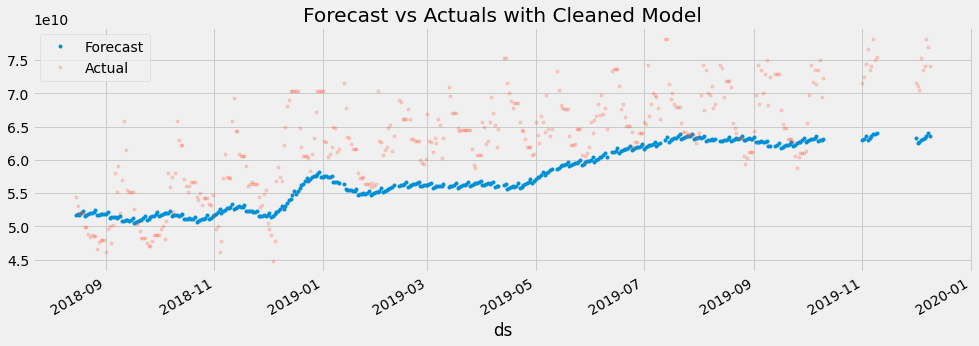

In [ ]:
ax = data_test_fcst_clean.set_index('ds')['yhat'] \
    .plot(figsize=(15, 5), lw=0, style='.')
data_test['val'].plot(ax=ax, style='.', lw=0, alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals with Cleaned Model')
plt.show()